Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


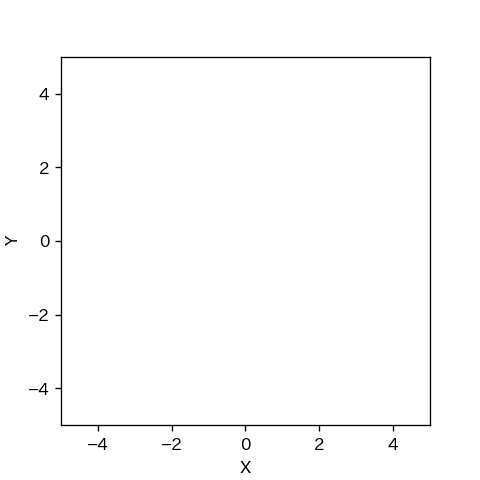

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs=np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id=observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p,self.map.landmarks[landmark_id].pos,*values)
            
        print(list([obs[0][0] for obs in observation]))
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

In [3]:
def trial_kidnap(animation): ###mclkidnap1test
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
    
    world.draw()
    
    return(r.pose, pf.ml.pose)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>


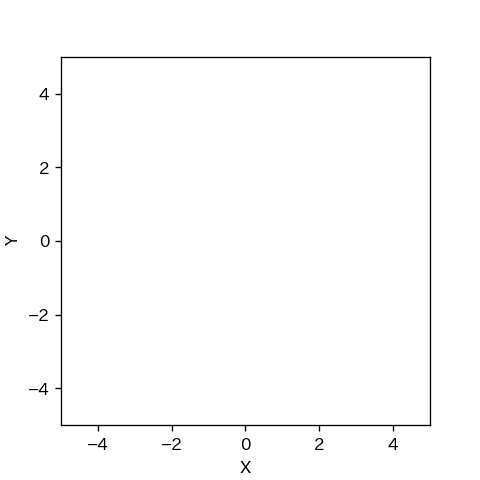

(array([-1.81911587,  2.28850865,  0.86251579]),
 array([ 3.78247671,  0.21426607, -0.23181222]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[2.6974403386996646]
0 真値: [ 2.00501581 -4.96325437  5.57134663] 推定値: [ 1.15848146 -4.31801907  4.96676733] 誤差: 1.0644007687450263
1 真値: [-3.83796318  3.53192143  8.35367766] 推定値: [-3.55211277  0.63339186  5.52346256] 誤差: 2.912590612305832
[4.116351467041509]
2 真値: [6.26907396 1.48148018 2.48529054] 推定値: [6.40569558 1.05537731 2.40989829] 誤差: 0.4474696884489476
1
[7.425999083733531]
3 真値: [-2.18128316  4.71551825  3.03680781] 推定値: [ 7.57790272 -1.16150601  5.47921661] 誤差: 11.392151819620068
[4.949924994924145]
4 真値: [ 0.24616082 -6.78598774  6.89839274] 推定値: [ 4.3272502   0.24408945 -2.59378028] 誤差: 8.128793011549105
[3.3555968282741238]
5 真値: [-0.61896721  0.4800518   3.93849568] 推定値: [-0.65499089 -0.11314134  3.79775137] 誤差: 0.5942859641311804
2
[4.547631619103267]
6 真値: [-1.12606974 -4.49100207  8.19628303] 推定値: [ 5.73980197 -1.74216809 -1.41779254] 誤差: 7.395693518553801
[4.639290095946727]
7 真値: [-3.92492379 -2.62689612  4.54792115] 推定値: [-4.43831067 -1.75549319  3.80825621] 誤差: 1.

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[2.459322608750862]
[6.723164674507565]
[6.290078645538053]
20 真値: [ 0.68522448 -0.84986518  3.75530202] 推定値: [-4.57349738 -3.96187895  2.52713046] 誤差: 6.110547052423725
[1.1534241192136108]
21 真値: [ 1.34978384 -4.36603383  6.52921039] 推定値: [ 1.26868097 -4.45198608  6.52416334] 誤差: 0.11817556813479674
11
[1.6568155028756653]
[5.871878981270828]
22 真値: [-2.66554225 -2.4627442   6.70405017] 推定値: [ 6.38746779 -3.87373482  3.42896461] 誤差: 9.162307855461872
[5.145395154900861]
23 真値: [-4.33880317 -4.11722358  7.68729871] 推定値: [-3.84693408  9.68613887  3.07744645] 誤差: 13.812123307386498
[5.0648943115385245]
24 真値: [4.989131   6.10805079 4.04870073] 推定値: [ 2.77562414  6.37339291 -1.6619571 ] 誤差: 2.2293539552326918
[1.0507651214500304]
[4.454759172839025]
[2.3597591304056458]
25 真値: [-3.38011404  4.59510505  3.56555904] 推定値: [-6.18476536  2.94273593 -1.31688019] 誤差: 3.255210088883
[2.3669404131053238, 4.50387711002857]
26 真値: [ 0.36093692 -0.56694802  6.35097382] 推定値: [ 0.54372781 -0.88395209 